In [118]:
! python3 -m pip install --upgrade pip
! python3 -m pip install  --upgrade SpeechRecognition
! python3 -m pip install  --upgrade pydub
! python3 -m pip install  --upgrade sklearn
! python3 -m pip install --upgrade textstat

In [119]:
import IPython.display as ipd
import joblib
import kapre
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
import textstat
import time
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from pydub.silence import split_on_silence 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [120]:
import warnings
warnings.filterwarnings('ignore')

# Transcribe audio data to txt data

In [121]:
# TODO make an input from user
data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train'

audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

lang_ = 'en-US'

In [122]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

meta['ID'] = meta['ID'].str.strip()

meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,NA,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [123]:
sum(meta.MMSE == ' NA')

1

In [124]:
# Replace all NAs
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

# TODO - see if this works - Replace all scores in cc group to 30
# meta.loc[meta['Group'] == 'cc', 'MMSE'] = 30
# meta

In [125]:
meta.dtypes

index      int64
ID        object
Age        int64
Gender    object
MMSE       int64
Group     object
dtype: object

In [126]:
# https://www.geeksforgeeks.org/python-speech-recognition-on-large-audio-files/
# a function that splits the audio file into chunks 
# and applies speech recognition 
def silence_based_conversion(path, inputfilename, lang = lang_): 
  
    full_path = path + inputfilename
    
    # open the audio file stored in 
    # the local system as a wav file. 
    song = AudioSegment.from_wav(full_path)
    
        # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(song, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 500, 
  
        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = -16
    )
    
    # create a directory to store the audio chunks. 
    try: 
        os.mkdir('audio_chunks') 
    except(FileExistsError): 
        pass

    # move into the directory to 
    # store the audio files. 
    os.chdir('audio_chunks') 
    
    # Create list to store text chunk
    text_list = []
    
    i = 0    
    # process each chunk 
    for chunk in chunks: 
              
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 10) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        print("saving chunk{0}.wav".format(i)) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("./chunk{0}.wav".format(i), bitrate ='192k', format ="wav") 
  
        # the name of the newly created chunk 
        filename = 'chunk'+str(i)+'.wav'
  
        print("Processing chunk "+str(i)) 
  
        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 
  
        # create a speech recognition object 
        r = sr.Recognizer() 
  
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            r.adjust_for_ambient_noise(source) 
            audio_listened = r.listen(source) 
  
        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file.
            text_list.append(rec)
  
        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 
  
        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 
  
        i += 1
  
    os.chdir('..')
    # return full audio sample as setences
    return text_list.join(". ")

In [127]:
text_dict = {"ID": [], "Text": []}

In [128]:
start_cc = time.time()
# Running for CC path
onlyfiles_cc = [f for f in listdir(audio_path_cc) if isfile(join(audio_path_cc, f))]

for filename in onlyfiles_cc:
    data = startConversion(path = audio_path_cc, filename = filename)
    just_name = filename.split(sep='.')[:-1][0]
    text_dict["ID"].append(just_name)
    text_dict["Text"].append(data)
end_cc = time.time()

start_cd = time.time()
# Running for CD path
onlyfiles_cd = [f for f in listdir(audio_path_cd) if isfile(join(audio_path_cd, f))]

for filename in onlyfiles_cd:
    data = startConversion(path = audio_path_cd, filename = filename)
    just_name = filename.split(sep='.')[:-1][0]
    text_dict["ID"].append(just_name)
    text_dict["Text"].append(data)
end_cd = time.time()

Transcribing file: S001.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S001.wav
Transcribing file: S002.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S002.wav
Transcribing file: S003.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S003.wav
Transcribing file: S004.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S004.wav
Transcribing file: S005.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S005.wav
Error:  <- this guy
Transcribing file: S006.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S006.wav
Error:  <- this guy
Transcribing file: S007.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio

Transcribing file: S084.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S084.wav
Transcribing file: S086.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S086.wav
Transcribing file: S087.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S087.wav
Transcribing file: S089.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S089.wav
Error:  <- this guy
Transcribing file: S090.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S090.wav
Transcribing file: S092.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S092.wav
Transcribing file: S093.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S093.wav
Transcr

In [129]:
time_cc = end_cc-start_cc
print("CC transcription time: " + str(time_cc) + " seconds.")

CC transcription time: 764.429705619812 seconds.


In [130]:
time_cd = end_cd-start_cd
print("CD transcription time: " + str(time_cd) + " seconds.")

CD transcription time: 653.4298467636108 seconds.


In [131]:
# Convert the dictionary into DataFrame 
text_df = pd.DataFrame(text_dict)
text_df

,ID,Text
0,S001,tell me everything that you see going on in th...
1,S002,picture
2,S003,okay there's a little boy and he's getting he ...
3,S004,Homedics laugh you ready well the sink is over...
4,S005,None
...,...,...
103,S150,now the boy on the chair is falling reaching u...
104,S151,everything that you see happening in that pict...
105,S153,and tell me everything that you see happening ...
106,S154,okay and the boys getting in the cookie jar is...


In [132]:
print(text_df["Text"][0])

tell me everything that you see going on in that picture everything that you see happening or washing the dishes in the sink is over spilling and windows open and outside the window there's a walk or Kirk walk with a garden and you can stay another building their looks like a garage or something with curtain grass in the garden and their dishes to cups and saucer on the sink overflow of the water from the sink is overflowing


In [99]:
merged_data = pd.merge(meta, text_df, on = "ID", how = "inner")
merged_data

,index,ID,Age,Gender,MMSE,Group,Text
0,0,S001,74,male,30,cc,tell me everything that you see going on in th...
1,1,S002,62,female,30,cc,picture
2,2,S003,69,female,29,cc,okay there's a little boy and he's getting he ...
3,3,S004,71,female,30,cc,Homedics laugh you ready well the sink is over...
4,4,S005,74,female,30,cc,None
...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,now the boy on the chair is falling reaching u...
104,50,S151,72,male,24,cd,everything that you see happening in that pict...
105,51,S153,68,female,12,cd,and tell me everything that you see happening ...
106,52,S154,65,female,20,cd,okay and the boys getting in the cookie jar is...


### Making some relevant columns categorical

In [54]:
# Make dummy categorical values and remove redundant first column
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Group'], drop_first=True)
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd
0,0,S001,74,30,tell me everything that you see going on in th...,1,0
1,1,S002,62,30,picture,0,0
2,2,S003,69,29,okay there is a little boy and he's getting he...,0,0
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0
...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1
97,50,S151,72,24,everything that you see happening in that pict...,1,1
98,51,S153,68,12,and tell me everything that you see happening ...,0,1
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1


# Reduce output labels by bucketizing

Reference: https://pubmed.ncbi.nlm.nih.gov/16473978/
MMSE ranges:
* 30 for no
* 26-29 for questionable
* 21-25 for mild
* 11-20 for moderate
* 0-10 for severe dementia

In [55]:
# Set a default value
merged_data['dementia_stage_num'] = 0
merged_data['dementia_stage_text'] = 'None'

In [56]:
# Set dementia stage value for all row indexes which MMSE are in certain ranges

# Mild stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 1
merged_data['dementia_stage_text'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 'Mild'

# Moderate/Severe stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] < 21)] = 2
merged_data['dementia_stage_text'][(merged_data['MMSE'] < 21)] = 'Moderate/Severe'

merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None
1,1,S002,62,30,picture,0,0,0,None
2,2,S003,69,29,okay there is a little boy and he's getting he...,0,0,1,Mild
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0,0,None
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0,0,None
...,...,...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1,2,Moderate/Severe
97,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild
98,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe


In [57]:
# See number of each type
print(merged_data['dementia_stage_num'].value_counts())

2    39
1    39
0    23
Name: dementia_stage_num, dtype: int64


### Adding readability consensus score as a feature

In [58]:
start = time.time()
# add an empty column 
merged_data['readability_score_consensus'] = '' 

# Returns estimated grade level for readability - e.g. '9' means appropriate for the 9th grade
for i in merged_data.index:
    merged_data.loc[i, 'readability_score_consensus'] = textstat.text_standard(merged_data.loc[i, 'Text'], float_output=True)

end = time.time()
    
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text,readability_score_consensus
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None,28
1,1,S002,62,30,picture,0,0,0,None,0
2,2,S003,69,29,okay there is a little boy and he's getting he...,0,0,1,Mild,0
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0,0,None,9
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0,0,None,14
...,...,...,...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1,2,Moderate/Severe,8
97,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild,20
98,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe,10
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe,21


In [59]:
print("This took: " + str(end-start) + " seconds")

This took: 0.10331439971923828 seconds


## Vectorize test data

In [60]:
# Vectorize text data so model can take it in
# TODO make it so english is not hardcoded, flexible for all languages
# https://www.justintodata.com/logistic-regression-example-in-python/
# https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(merged_data['Text'])
vectorizedTextDF = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names())
print(vectorizedTextDF)

      10  104  303   40    about  acting  action  active  ahead       all  \
0    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
1    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
2    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.081485   
3    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
4    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.171352   
..   ...  ...  ...  ...      ...     ...     ...     ...    ...       ...   
96   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
97   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
98   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
99   0.0  0.0  0.0  0.0  0.17899     0.0     0.0     0.0    0.0  0.000000   
100  0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   

     ...      with  woman   working  yard  year  yet       you  young  \
0 

### Get model columns only

In [61]:
merged_data_useful_cols = merged_data[["Age", "Gender_ male ", "readability_score_consensus"]]
X_data = pd.concat([merged_data_useful_cols, vectorizedTextDF], axis=1)

# y_data = merged_data[["dementia_stage_num"]]
y_data = merged_data[["MMSE"]]

In [62]:
X_data

,Age,Gender_ male,readability_score_consensus,10,104,303,40,about,acting,action,...,with,woman,working,yard,year,yet,you,young,youngster,your
0,74,1,28,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.208362,0.0,0.000000,0.0,0.0,0.0,0.164697,0.0,0.0,0.000000
1,62,0,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,69,0,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.274953,0.0,0.000000,0.0,0.0,0.0,0.048296,0.0,0.0,0.000000
3,71,0,9,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.100045,0.0,0.0,0.000000
4,67,1,14,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,58,1,8,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.220035
97,72,1,20,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.239497,0.0,0.0,0.0,0.241061,0.0,0.0,0.000000
98,68,0,10,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.159917,0.0,0.0,0.000000
99,65,0,21,0.0,0.0,0.0,0.0,0.17899,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [63]:
y_data

,MMSE
0,30
1,30
2,29
3,30
4,30
...,...
96,20
97,24
98,12
99,20


# Split dataset

In [64]:
# dividing X, y into train and test data 
# 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
print("Training data set is length: " +str(len(y_train)))
print("Test data set is length: " +str(len(y_test)))

Training data set is length: 80
Test data set is length: 21


In [111]:
y_test

,MMSE
40,29
5,30
55,21
41,29
35,30
75,10
7,30
65,14
9,30
39,30


# Train and predict on Logistic regression

In [65]:
start = time.time()

param_values = {
                'penalty' : ['l1', 'l2'],
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'max_iter' : [10000]
           }

# Try out the different n_estimators parameters
lr_model = GridSearchCV(estimator = LogisticRegression(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

lr_model.fit(X_train, y_train)

best_lr_C_value = lr_model.best_params_['C']
best_penalty_value = lr_model.best_params_['penalty']

print("Best C: " + str(best_lr_C_value) + ", best penalty: " + str(best_penalty_value))
lr_pred = lr_model.predict(X_test)
end=time.time()
print(classification_report(lr_pred, y_test))

Best C: 0.01, best penalty: l2
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         8
          30       0.57      0.33      0.42        12

    accuracy                           0.19        21
   macro avg       0.05      0.03      0.04        21
weighted avg       0.33      0.19      0.24        21



In [66]:
print("This took: " + str(end-start) + " seconds")

This took: 549.9517185688019 seconds


In [106]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=lr_pred, squared=False))

Accuracy:  0.19047619047619047
RMSE:  7.791937224739796


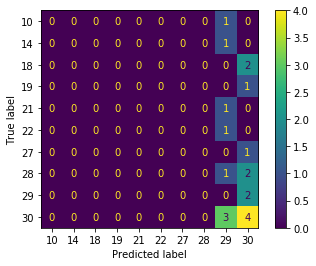

In [116]:
# Create and show confusion matrix
plot_confusion_matrix(lr_model, X_test, y_test, labels=np.unique(y_test))
plt.show()  

In [134]:
# save the model to disk at current working directory
# filename = 'logistic_regression_model.pkl'
# joblib.dump(lr_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(X_train.columns)
# joblib.dump(model_columns, 'logistic_regression_model_columns.pkl')

['logistic_regression_model_columns.pkl']

# SVM multi class classification based on stage

In [69]:
# Should be same data
# 'OVO' gets better results for some reason
# Linear kernel gets better results for some reason
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
start=time.time()

param_values = {
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                'decision_function_shape' : ['ovo']
           }

# Try out the different n_estimators parameters
svm_model = GridSearchCV(estimator = SVC(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

best_svm_C_value = svm_model.best_params_['C']
best_kernel_value = svm_model.best_params_['kernel']

print("Best C: " + str(best_svm_C_value) + ", best kernel: " + str(best_kernel_value))

end=time.time()

print(classification_report(svm_pred, y_test))

Best C: 1, best kernel: poly
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          29       0.33      0.14      0.20         7
          30       0.86      0.43      0.57        14

    accuracy                           0.33        21
   macro avg       0.12      0.06      0.08        21
weighted avg       0.68      0.33      0.45        21



In [71]:
print("This took: " + str(end-start) + " seconds")

This took: 5.5682008266448975 seconds


In [107]:
print("Accuracy: ", accuracy_score(y_test, svm_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=svm_pred, squared=False))

Accuracy:  0.3333333333333333
RMSE:  7.332251002380153


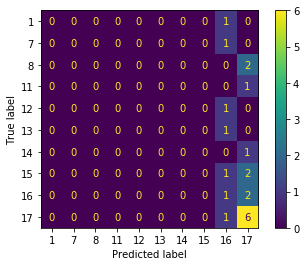

In [73]:
# Create and show confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()  

In [103]:
# save the model to disk at current working directory
# filename = 'svm_model.pkl'
# joblib.dump(svm_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'svm_model_columns.pkl')

['svm_model.pkl']

# Random forest classifier

In [74]:
# creating a RF classifier 
random_forest = RandomForestClassifier()   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
random_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
start=time.time()

n_estimators_values = {'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

# Try out the different n_estimators parameters
rf_model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = n_estimators_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)

best_n_estimators = rf_model.best_params_['n_estimators']
print("best n_estimators: " + str(best_n_estimators))

end=time.time()

print(classification_report(rf_pred, y_test))

best n_estimators: 1000
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         0
          28       0.33      1.00      0.50         1
          29       0.00      0.00      0.00         7
          30       0.29      0.22      0.25         9

    accuracy                           0.14        21
   macro avg       0.05      0.09      0.06        21
weighted avg       0.14      0.14      0.13        21



In [76]:
print("This took: " + str(end-start) + " seconds")

This took: 20.963252305984497 seconds


In [108]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, rf_pred)) 

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=rf_pred, squared=False))

ACCURACY OF THE MODEL:  0.14285714285714285
RMSE:  7.88005317845242


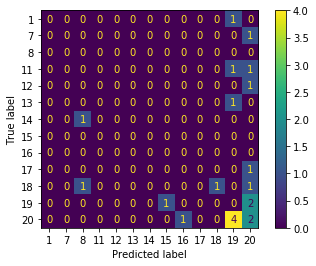

In [78]:
# Create and show confusion matrix
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()  

In [104]:
# save the model to disk at current working directory
# filename = 'rf_model.pkl'
# joblib.dump(rf_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'rf_model_columns.pkl')

['rf_model.pkl']

# Neural net

In [ ]:
start=time.time()

# Set up N-fold cross validation to find best parameters
parameters = {    
    'hidden_layer_sizes': [
        (1,), (2,), (5,), (10,), (20,), (50,), (100,),
        (1,1), (2,2), (5,5), (10,10), (20,20), (50,50), (100,100),
        (1,1,1), (2,2,2), (5,5,5), (10,10,10), (20,20,20), (50,50,50), (100,100,100)
    ], 
    'activation': ["logistic", "relu", "tanh"],
    'solver': ['lbfgs'], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'max_iter': [200, 500, 1000], 
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7,1e-8],
    'verbose' : [True] # to print out messages for debugging later
}

# n_jobs -1 maximizes jobs in background
clf = GridSearchCV(MLPClassifier(), parameters, cv = None, scoring = 'accuracy', n_jobs=-1)

# Create train and test the model
clf.fit(X_train, y_train)
# best_score = clf.score(X_test, y_test)
    
# Print the classification report for the NN model
mlp_pred = clf.predict(X_test)

print("Best parameters are: ")
print(clf.best_params_)
print("Classification report starts here: ")
print(classification_report(mlp_pred, y_test))
end=time.time()

In [ ]:
print("This took: " + str(end-start) + " seconds")

In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, mlp_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=mlp_pred, squared=False))

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()  

In [ ]:
# save the model to disk at current working directory
# filename = 'nn_model.pkl'
# joblib.dump(clf, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'nn_model_columns.pkl')